# Snippets

In [233]:
import numpy as np
from scipy.linalg import eig, eigh
import pandas as pd
from matplotlib.pyplot import plot, scatter
import seaborn as sns
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

In [234]:
n = 10
max_d = 3
c = 2
X = list()
y = list()
# 1D, 2D, 3D with 2 clusters each; other dimensions uniform rnd noise
for i in range(1, max_d+1):
    d = i
    # Generate Gaussian clusters
    Xi, yi = make_blobs(n_samples=n, n_features=d, centers=c)
    # Unif. rnd. noise in other features
    Xi_rnd = np.random.rand(n, max_d-i) * 100
    Xi = np.block([Xi, Xi_rnd])
    X.append(Xi)
    # Make sure labels are not accidentally overlapping
    y.append(yi + (i-1)*c)
    del Xi, yi, Xi_rnd
# Combine dataset and labels
X = np.block([[x] for x in X])
y = np.block(y)
df = pd.DataFrame(X, columns=[f'x{x}' for x in range(d)])
X_df = df.copy()
Xy_df = df.copy()
Xy_df['y'] = y
Xy_df

,x0,x1,x2,y
0,1.180753,48.511796,68.971064,0
1,1.893963,50.188201,13.857611,1
2,0.696581,18.897070,67.319263,0
3,-0.499015,86.548416,59.639888,0
4,0.917108,99.728588,12.684182,1
5,0.486446,27.966393,30.112804,1
6,-0.211245,85.282963,84.141509,0
7,1.643515,45.494624,68.831321,1
8,1.347762,85.761989,74.020321,1
9,0.152745,31.986734,82.885846,0


In [288]:
n = 30
d = 3
c = 3
# Generate Gaussian clusters
X, y = make_blobs(n_samples=n, n_features=d, centers=c, random_state=456)
X[:, 2] = np.random.rand(n) # Overwrite with unif. noise
df = pd.DataFrame(X, columns=[f'x{x}' for x in range(d)])
X_df = df.copy()
Xy_df = df.copy()
Xy_df['y'] = y
Xy_df

,x0,x1,x2,y
0,8.112639,5.168822,0.675788,2
1,7.094015,4.323381,0.732914,2
2,4.925731,3.945118,0.183462,1
3,6.102974,2.232397,0.582020,1
4,-6.491476,-5.446146,0.350774,0
5,7.973228,6.246693,0.542551,2
6,7.560295,4.988918,0.543670,2
7,-6.921782,-6.298256,0.561245,0
8,-4.158477,-7.707842,0.115769,0
9,-5.360984,-7.167427,0.280514,0


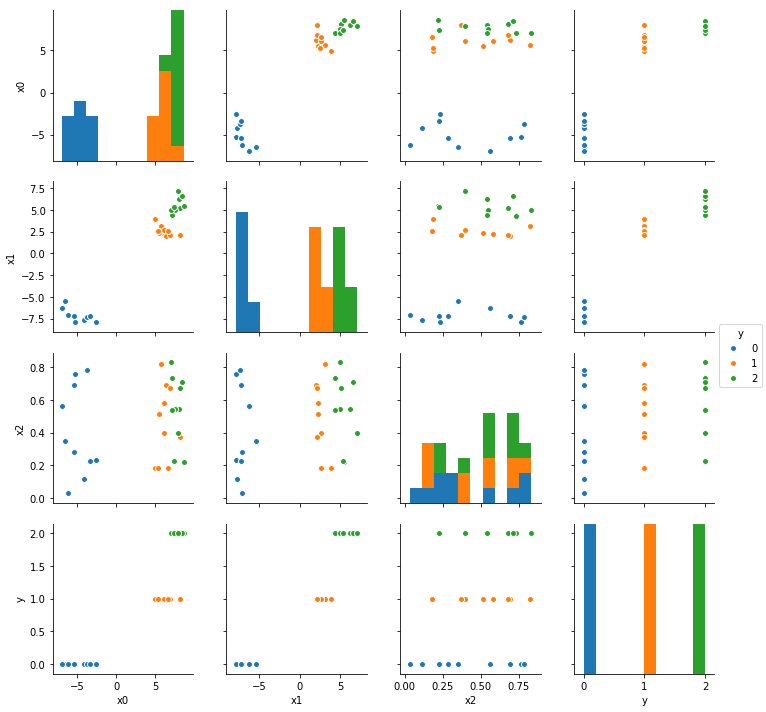

In [289]:
sns.pairplot(Xy_df, hue='y');

## COPAC

In [237]:
from multiprocessing import cpu_count

import numpy as np
from scipy import sparse
from scipy import linalg as LA
from scipy.spatial.distance import squareform

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster.dbscan_ import dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_array, check_consistent_length


def _cdist(P, Q, Mhat_P):
    """ Correlation distance between P and Q (not symmetric).

    Notes
    -----
    The squareroot of cdist is taken later. The advantage here is to
    save some computation, as we can first take the maximum of
    two cdists, and then take the root of the 'winner' only.
    """
    PQ_diff = P - Q
    return PQ_diff @ Mhat_P @ PQ_diff.T


def copac(X, k=10, mu=5, eps=0.5, alpha=0.85, metric='euclidean',
          metric_params=None, algorithm='auto', leaf_size=30, p=None,
          n_jobs=1, sample_weight=None):
    """Perform COPAC clustering from vector array.
    Read more in the :ref:`User Guide <copac>`.

    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        A feature array.
    k : int, optional, default=10
        Size of local neighborhood for local correlation dimensionality.
        The paper suggests k >= 3 * n_features.
    mu : int, optional, default=5
        Minimum number of points in a cluster with mu <= k.
    eps : float, optional, default=0.5
        Neighborhood predicate, so that neighbors are closer than `eps`.
    alpha : float in ]0,1[, optional, default=0.85
        Threshold of how much variance needs to be explained by Eigenvalues.
        Assumed to be robust in range 0.8 <= alpha <= 0.9 [see Ref.]
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string or callable, it must be one of
        the options allowed by sklearn.metrics.pairwise.pairwise_distances
        for its metric parameter.
        If metric is "precomputed", `X` is assumed to be a distance matrix and
        must be square.
    metric_params : dict, optional
        Additional keyword arguments for the metric function.
    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        The algorithm to be used by the scikit-learn NearestNeighbors module
        to compute pointwise distances and find nearest neighbors.
        See NearestNeighbors module documentation for details.
    leaf_size : int, optional (default = 30)
        Leaf size passed to BallTree or cKDTree. This can affect the speed
        of the construction and query, as well as the memory required
        to store the tree. The optimal value depends
        on the nature of the problem.
    p : float, optional
        The power of the Minkowski metric to be used to calculate distance
        between points.
    n_jobs : int, optional, default=1
        Number of parallel processes. Use all cores with n_jobs=-1.
    sample_weight : None
        Currently ignored

    Returns
    -------
    labels : array [n_samples]
        Cluster labels for each point. Noisy samples are given the label -1.

    References
    ----------
    Elke Achtert, Christian Bohm, Hans-Peter Kriegel, Peer Kroger,
    A. Z. (n.d.). Robust, complete, and efficient correlation
    clustering. In Proceedings of the Seventh SIAM International
    Conference on Data Mining, April 26-28, 2007, Minneapolis,
    Minnesota, USA (2007), pp. 413–418.
    """
    X = check_array(X)
    n, d = X.shape
    y = -np.ones(n, dtype=np.int)
    if n_jobs == -1:
        n_jobs = cpu_count()

    # Calculating M^ just once requires lots of memory...
    lambda_ = np.zeros(n, dtype=int)
    M_hat = list()

    # Get nearest neighbors
    nn = NearestNeighbors(n_neighbors=k, metric=metric,
                          n_jobs=n_jobs)
    nn.fit(X)
    knns = nn.kneighbors(return_distance=False)
    for P, knn in enumerate(knns):
        N_P = X[knn]

        # Corr. cluster cov. matrix
        # TODO Is this an input parameter?
        features = ... #[0, 1, 2, ...]   # subset of dimensions
        Sigma_C = np.cov(N_P[:, features], rowvar=False, ddof=0)

        # Decompose spsd matrix, and sort Eigenvalues descending
        E_C, V_C = LA.eigh(Sigma_C)
        E_C = np.sort(E_C)[::-1]

        # Local correlation dimension
        explanation_portion = np.cumsum(E_C) / E_C.sum()
        lambda_P = np.searchsorted(explanation_portion, alpha, side='left')
        lambda_P += 1
        lambda_[P] = lambda_P
        # Correlation distance matrix
        E_hat = (np.arange(1, d + 1) > lambda_[P]).astype(int)
        M_hat.append(V_C @ np.diag(E_hat) @ V_C.T)
        
    # Group pts by corr. dim.
    argsorted = np.argsort(lambda_)
    edges, _ = np.histogram(lambda_[argsorted], bins=np.arange(1, d+2))
    Ds = np.split(argsorted, np.cumsum(edges))
    # Loop over partitions according to local corr. dim.
    max_label = 0
    used_y = np.zeros_like(y, dtype=bool)
    for D in Ds:
        n_D = D.shape[0]
        cdist = -np.ones((n_D * (n_D - 1) // 2, 2), dtype=np.float)
        ind = 0
        # Calculate triu part of distance matrix
        for i in range(0, n_D - 1):
            p = D[i]
            # TODO vectorize inner loop
            for j in range(i + 1, n_D):
                q = D[j]
                cdist[ind, 0] = _cdist(X[p], X[q], M_hat[p])
                cdist[ind, 1] = _cdist(X[q], X[p], M_hat[q])
                ind += 1
        # Square root of the higher value of cdist_P, cdist_Q
        cdist = np.sqrt(cdist.max(axis=1))

        # Perform DBSCAN with full distance matrix
        cdist = squareform(cdist)
        clust = dbscan(X=cdist, eps=eps, min_samples=mu,
                       metric='precomputed', n_jobs=n_jobs)
        _, labels = clust
        # Each DBSCAN run is unaware of previous ones,
        # so we need to keep track of previous cluster IDs
        y_D = labels + max_label
        new_labels = np.unique(labels[labels>=0]).size
        max_label += new_labels
        # TODO check correct indexing of label array `y`
        y[D] = y_D
        used_y[D] = True
    assert np.all(used_y), "Not all samples got labels!"
    return y


class COPAC(BaseEstimator, ClusterMixin):
    """Perform COPAC clustering from vector array.
    Read more in the :ref:`User Guide <copac>`.

    Parameters
    ----------
    k : int, optional, default=10
        Size of local neighborhood for local correlation dimensionality.
        The paper suggests k >= 3 * n_features.
    mu : int, optional, default=5
        Minimum number of points in a cluster with mu <= k.
    eps : float, optional, default=0.5
        Neighborhood predicate, so that neighbors are closer than `eps`.
    alpha : float in ]0,1[, optional, default=0.85
        Threshold of how much variance needs to be explained by Eigenvalues.
        Assumed to be robust in range 0.8 <= alpha <= 0.9 [see Ref.]
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string or callable, it must be one of
        the options allowed by sklearn.metrics.pairwise.pairwise_distances
        for its metric parameter.
        If metric is "precomputed", `X` is assumed to be a distance matrix and
        must be square.
    metric_params : dict, optional
        Additional keyword arguments for the metric function.
    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        The algorithm to be used by the scikit-learn NearestNeighbors module
        to compute pointwise distances and find nearest neighbors.
        See NearestNeighbors module documentation for details.
    leaf_size : int, optional (default = 30)
        Leaf size passed to BallTree or cKDTree. This can affect the speed
        of the construction and query, as well as the memory required
        to store the tree. The optimal value depends
        on the nature of the problem.
    p : float, optional
        The power of the Minkowski metric to be used to calculate distance
        between points.
    n_jobs : int, optional, default=1
        Number of parallel processes. Use all cores with n_jobs=-1.

    Attributes
    ----------
    labels_ : array, shape = [n_samples]
        Cluster labels for each point in the dataset given to fit().
        Noisy samples are given the label -1.

    Notes
    -----
    ...
    References
    ----------
    Elke Achtert, Christian Bohm, Hans-Peter Kriegel, Peer Kroger,
    A. Z. (n.d.). Robust, complete, and efficient correlation
    clustering. In Proceedings of the Seventh SIAM International
    Conference on Data Mining, April 26-28, 2007, Minneapolis,
    Minnesota, USA (2007), pp. 413–418.
    """

    def __init__(self, k=10, mu=5, eps=0.5, alpha=0.85, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=1):
        self.k = k
        self.mu = mu
        self.eps = eps
        self.alpha = alpha
        self.metric = metric
        self.metric_params = metric_params
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.p = p
        self.n_jobs = n_jobs

    def fit(self, X, y=None, sample_weight=None):
        """Perform COPAC clustering from features.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            A feature array.
        sample_weight : array, shape (n_samples,), optional
            Weight of each sample, such that a sample with a weight of at least
            ``min_samples`` is by itself a core sample; a sample with negative
            weight may inhibit its eps-neighbor from being core.
            Note that weights are absolute, and default to 1.
        y : Ignored
        """
        X = check_array(X)
        clust = copac(X, sample_weight=sample_weight,
                       **self.get_params())
        self.labels_ = clust
        return self

    def fit_predict(self, X, y=None, sample_weight=None):
        """Performs clustering on X and returns cluster labels.

        Parameters
        ----------
        X : ndarray matrix of shape (n_samples, n_features)
            A feature array.
        sample_weight : array, shape (n_samples,), optional
            Weight of each sample, such that a sample with a weight of at least
            ``min_samples`` is by itself a core sample; a sample with negative
            weight may inhibit its eps-neighbor from being core.
            Note that weights are absolute, and default to 1.
        y : Ignored

        Returns
        -------
        y : ndarray, shape (n_samples,)
            cluster labels
        """
        self.fit(X, sample_weight=sample_weight)
        return self.labels_


In [290]:
from scipy.spatial.distance import squareform, pdist
eucl_dist = squareform(pdist(X, metric='euclidean'))
#eucl_dist.mean(axis=0)
eucl_dist

array([[  0.        ,   1.32500176,   3.4490895 ,   3.55951403,
         18.05722407,   1.09498543,   0.59573913,  18.90874964,
         17.79613393,  18.272323  ,  18.67173671,  17.23894403,
          0.74595369,   1.28177538,   3.1519525 ,   1.10336488,
          3.65492159,  18.28901642,   1.43171497,  18.8329905 ,
         16.81956715,   3.90369876,   3.18427114,   3.87458499,
          0.83017132,   3.31630985,   2.01312744,   3.02053282,
         16.90342147,   3.01417392],
       [  1.32500176,   0.        ,   2.26857512,   2.31886721,
         16.73783822,   2.12329539,   0.83436765,  17.58667663,
         16.48483413,  16.95200023,  17.35252992,  15.9249686 ,
          1.978867  ,   0.21171979,   1.8270466 ,   0.72471304,
          2.460415  ,  16.96715343,   2.61430494,  17.51242402,
         15.52471999,   2.60411878,   1.92293026,   2.58182934,
          1.19690251,   2.22326431,   2.95905792,   1.87217748,
         15.59457661,   2.39657492],
       [  3.4490895 ,   2.2685

In [291]:
clst = COPAC(k=20, mu=8, eps=2, algorithm='brute')
y_pred = clst.fit_predict(X)

In [292]:
print(y_pred)
print(y)
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score, v_measure_score, normalized_mutual_info_score
print(adjusted_mutual_info_score(y, y_pred))
print(normalized_mutual_info_score(y, y_pred))
print(v_measure_score(y, y_pred))

[ 0  0  0  0 -1  0  0  1  1  1  1  1  0  0  0  0  0  1  0  1 -1  0  0  0  0
  0  0  0  1  0]
[2 2 1 1 0 2 2 0 0 0 0 0 2 2 1 2 1 0 2 0 0 1 1 1 2 1 2 1 0 1]
0.54569272606
0.67755244543
0.669335973117


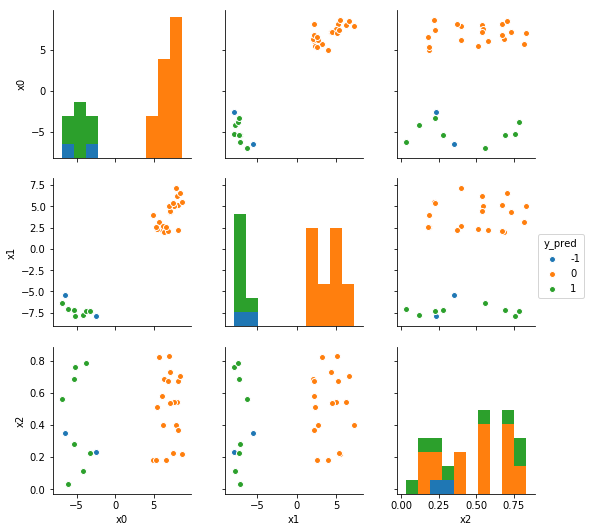

In [293]:
Xy_df['y_pred'] = y_pred
sns.pairplot(Xy_df, x_vars=['x0', 'x1', 'x2'], y_vars=['x0', 'x1', 'x2'], hue='y_pred');